# 3'UTR Search 

## 1. Import packages

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 2. Open and read data files

In [2]:
'''
Opening data files and adding a column to describe their strand: 
    Forward or Reverse are (+) or (-) strand respectively. 
    Sample refers to the biological replicate from which the data was obtained. 
    There is one forward and one reverse strand dataframe for each sample
'''
#Stranded read count csv files from CATS-seq data
forward_1 = pd.read_csv('/Users/kershtheva/Desktop/Thesis/Chapter_4/terminatorID/forwardStrand_1.csv')
forward_2 = pd.read_csv('/Users/kershtheva/Desktop/Thesis/Chapter_4/terminatorID/forwardStrand_2.csv')
forward_3 = pd.read_csv('/Users/kershtheva/Desktop/Thesis/Chapter_4/terminatorID/forwardStrand_3.csv')
reverse_1 = pd.read_csv('/Users/kershtheva/Desktop/Thesis/Chapter_4/terminatorID/reverseStrand_1.csv')
reverse_2 = pd.read_csv('/Users/kershtheva/Desktop/Thesis/Chapter_4/terminatorID/reverseStrand_2.csv')
reverse_3 = pd.read_csv('/Users/kershtheva/Desktop/Thesis/Chapter_4/terminatorID/reverseStrand_3.csv')

#List of genes by number, start position, stop position and strand 
geneList = pd.read_csv('/Users/kershtheva/Desktop/Thesis/Chapter_4/RockhopperGeneList.csv')

#Predicted operons from rockhopper, with some manual adjustments
operonList = pd.read_csv('/Users/kershtheva/Desktop/Thesis/Chapter_4/Operons.csv')


## 3. Change categorical names to numericals

In [3]:
#Classify strand and samples based on IGV visualization and bowtie/samtools preprocessing.
forward_1 = forward_1.rename(columns={'Counts':'Counts_F1'})
reverse_1 = reverse_1.rename(columns={'Counts':'Counts_R1'})
forward_2 = forward_2.rename(columns={'Counts':'Counts_F2'})
reverse_2 = reverse_2.rename(columns={'Counts':'Counts_R2'})
forward_3 = forward_3.rename(columns={'Counts':'Counts_F3'})
reverse_3 = reverse_3.rename(columns={'Counts':'Counts_R3'})


## 4. Merging dataFrames with concatenation

Taking a look at the data above, it appears that reverse_3 df has the 'largest' position at nt 1660917. Next, we will attempt to merge these dataFrames into one dataFrame that contains the following columns: 

1. **Position** (done)
2. **CATS-Seq Pos Mean Counts** 
3. **CATS-Seq Neg Mean Counts** 
4. **Gene Start** (done)
5. **Gene End** (done) 
6. **Gene Strand** (done)
7. **Gene ID** (done)
8. **Gene Name** (done)
9. **Number of genes in operon** 
10. **Predicted operon 3' UTR** (done)
11. **Predicted operon 5' UTR** (done)

At the end, I would also like to KDE or histograms for read count density vs. distance from gene for 1,2,3 and 4 terms and a reannotated "GFF-like" file with operon and UTR info.

Next, we can try using the [concat](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#the-merge-indicator) method. 

In [4]:
#Concatenate all 6 csv files along the columns (axis=0), sort to preserve order
allCounts_preConcatenation = [forward_1, forward_2, forward_3, reverse_1, reverse_2, reverse_3]
allCounts = pd.concat(allCounts_preConcatenation, ignore_index=True, axis=0, sort=True)
allCounts.fillna(0, inplace=True)


In [107]:
allCounts.tail(15)

,Counts_F1,Counts_F2,Counts_F3,Counts_R1,Counts_R2,Counts_R3,Position
1302074,0.0,0.0,0.0,0.0,0.0,1.0,1660903
1302075,0.0,0.0,0.0,0.0,0.0,1.0,1660904
1302076,0.0,0.0,0.0,0.0,0.0,1.0,1660905
1302077,0.0,0.0,0.0,0.0,0.0,1.0,1660906
1302078,0.0,0.0,0.0,0.0,0.0,1.0,1660907
1302079,0.0,0.0,0.0,0.0,0.0,1.0,1660908
1302080,0.0,0.0,0.0,0.0,0.0,1.0,1660909
1302081,0.0,0.0,0.0,0.0,0.0,1.0,1660910
1302082,0.0,0.0,0.0,0.0,0.0,1.0,1660911
1302083,0.0,0.0,0.0,0.0,0.0,1.0,1660912


In [5]:
#---Get a mean for every row of forward strand counts---
allCounts['Forward Mean'] = allCounts.iloc[:,:3].apply(lambda x: x.mean(), axis=1)


In [6]:
#---Get a mean for every row of reverse strand counts---
allCounts['Reverse Mean'] = allCounts.iloc[:,3:6].apply(lambda x: x.mean(), axis=1)


In [11]:
#---Drop columns in allCounts that are not needed anymore---
allCountsClean = allCounts.drop(columns = ['Counts_F1', 'Counts_F2', 'Counts_F3', 
                                           'Counts_R1', 'Counts_R2', 'Counts_R3'], axis=1)


In [117]:
allCountsClean.head()

,Position,Forward Mean,Reverse Mean,+ Strand,- Strand
0,65,3.666667,0.0,1,0
1,66,4.000000,0.0,1,0
2,67,4.000000,0.0,1,0
3,68,4.333333,0.0,1,0
4,69,4.666667,0.0,1,0


In [8]:
#Make a column with the strand information. 
#+ Strand: 1 if there is a non-zero value, 0 if not in + strand.
#- Strand: 1 if there is a non-zero value, 0 if not in - strand.

allCountsClean['+ Strand'] = allCountsClean['Forward Mean'].apply(lambda x: 1 if x>0 else 0)
allCountsClean['- Strand'] = allCountsClean['Reverse Mean'].apply(lambda x: 1 if x>0 else 0)



In [9]:
#Merge values of reverse mean with forward mean 
allCountsClean['Mean'] = np.where(allCountsClean['Forward Mean'].eq(0), allCountsClean['Reverse Mean'], allCountsClean['Forward Mean'])


In [10]:
#Drop mean columns "Forward Mean" and "Reverse Mean"
allCountsClean.drop(columns = ['Forward Mean', 'Reverse Mean'], axis = 1, inplace=True)


In [124]:
allCountsClean.head()

,Position,+ Strand,- Strand,Mean
0,65,1,0,3.666667
1,66,1,0,4.000000
2,67,1,0,4.000000
3,68,1,0,4.333333
4,69,1,0,4.666667


In [12]:
#Drop duplicate rows from position.
allCountsClean2 = allCountsClean.drop_duplicates('Position')


In [13]:
allCountsClean2 = allCountsClean2.reset_index()

## Gene List

In [137]:
geneList.head()

,Seqname,Source,Feature,Start,End,Score,Strand,Frame,Attribute
0,gi|45357563|ref|NC_005791.1|,RefSeq,RNA,68,182,.,-,.,"name=rrnA5S;product=""5S ribosomal RNA"""
1,gi|45357563|ref|NC_005791.1|,RefSeq,RNA,244,3200,.,-,.,"name=rrnA23S;product=""23S ribosomal RNA"""
2,gi|45357563|ref|NC_005791.1|,RefSeq,RNA,3402,4793,.,-,.,"name=rrnA16S;product=""16S ribosomal RNA"""
3,gi|45357563|ref|NC_005791.1|,RefSeq,RNA,5109,5223,.,-,.,"name=rrnB5S;product=""5S ribosomal RNA"""
4,gi|45357563|ref|NC_005791.1|,RefSeq,RNA,5285,8241,.,-,.,"name=rrnB23S;product=""23S ribosomal RNA"""


In [14]:
#Remove unnecessary columns 
geneListSimple = geneList.drop(columns = ['Seqname', 'Source', 'Score', 'Frame'], axis=1)


In [15]:
#Do splits and renames for new columns Gene_ID and Gene Name 
geneListSimple['Gene_ID'] = geneListSimple['Attribute'].apply(lambda x: x.split(';')[0])
geneListSimple['Gene_ID'] = geneListSimple['Attribute'].apply(lambda x: x.replace('name=', ''))
geneListSimple['Gene_Name'] = geneListSimple['Attribute'].apply(lambda x: x.split('="')[1])


In [16]:
#Do splits and replaces on Gene_ID and Gene_Name columns again. 
geneListSimple['Gene_ID'] = geneListSimple['Gene_ID'].apply(lambda x: x.split(';product')[0])
geneListSimple['Gene_Name'] = geneListSimple['Gene_Name'].apply(lambda x: x.replace('"', ""))


In [17]:
#Drop now unnecessary columns
geneListSimple = geneListSimple.drop(columns=['Attribute','Feature'], axis=1)


In [18]:
#Modify Strand
geneListSimple['Strand'] = geneListSimple['Strand'].apply(lambda x: 0 if '-' in str(x) else 1)


In [143]:
geneListSimple.tail()

,Start,End,Strand,Gene_ID,Gene_Name
1767,1654349,1654681,0,MMP1718,hypothetical protein
1768,1654837,1657491,0,MMP1719,hypothetical protein
1769,1657683,1659479,1,MMP1720,hypothetical protein
1770,1659491,1660279,1,MMP1721,hypothetical protein
1771,1660311,1661129,1,hisF,imidazole glycerol phosphate synthase subunit ...


In [19]:
#Make Start Gene List
geneListSimpleStart = geneListSimple.drop(columns='End', axis=1)


In [85]:
geneListSimpleStart.head(10)

,Start,Strand,Gene_ID,Gene_Name
0,68,0,rrnA5S,5S ribosomal RNA
1,244,0,rrnA23S,23S ribosomal RNA
2,3402,0,rrnA16S,16S ribosomal RNA
3,5109,0,rrnB5S,5S ribosomal RNA
4,5285,0,rrnB23S,23S ribosomal RNA
5,8443,0,rrnB16S,16S ribosomal RNA
6,10104,1,MMP0001,hypothetical protein
7,10416,1,MMP0002,L-seryl-tRNA selenium transferase
8,11517,0,korA,2-oxoglutarate ferredoxin oxidoreductase subun...
9,12647,0,MMP0004,hypothetical protein


In [20]:
#Make Stop Gene List
geneListSimpleStop = geneListSimple.drop(columns=['Start'], axis=1)


In [155]:
geneListSimpleStop.head(10)

,End,Strand,Gene_ID,Gene_Name
0,182,0,rrnA5S,5S ribosomal RNA
1,3200,0,rrnA23S,23S ribosomal RNA
2,4793,0,rrnA16S,16S ribosomal RNA
3,5223,0,rrnB5S,5S ribosomal RNA
4,8241,0,rrnB23S,23S ribosomal RNA
5,9834,0,rrnB16S,16S ribosomal RNA
6,10385,1,MMP0001,hypothetical protein
7,11480,1,MMP0002,L-seryl-tRNA selenium transferase
8,12608,0,korA,2-oxoglutarate ferredoxin oxidoreductase subun...
9,13543,0,MMP0004,hypothetical protein


## Operon List

In [21]:
#Get rid of NaN values
operonList.fillna(0, inplace=True)


In [22]:
#Convert strand strings to integers
operonList['Strand'] = operonList['Strand'].apply(lambda x: 0 if '-' in str(x) else 1)


In [23]:
#Sort operonList 
operonList = operonList.sort_values(by=['Start'], ascending=True)


In [156]:
operonList.head()

,Start,Stop,Strand,5'UTR,3'UTR,Genes,Gene Names
13,10104,11480,1,0.0,0.0,2.0,"MMP0001, MMP0002"
14,11517,13543,0,0.0,0.0,2.0,"korA, MMP0004"
15,17602,20931,0,0.0,0.0,3.0,"DP1, MMP0009, MMP0010"
16,24061,26552,0,0.0,0.0,3.0,"truD, MMP0015, MMP0016"
17,30411,31567,0,0.0,0.0,2.0,"MMP0022, MMP0023"


In [24]:
#Perform similar operations as done on geneList i.e. make startlist and stoplist for merging with masterDB
operonStartList = operonList.drop(columns='Stop', axis=1)


In [158]:
operonStartList.head()

,Start,Strand,5'UTR,3'UTR,Genes,Gene Names
13,10104,1,0.0,0.0,2.0,"MMP0001, MMP0002"
14,11517,0,0.0,0.0,2.0,"korA, MMP0004"
15,17602,0,0.0,0.0,3.0,"DP1, MMP0009, MMP0010"
16,24061,0,0.0,0.0,3.0,"truD, MMP0015, MMP0016"
17,30411,0,0.0,0.0,2.0,"MMP0022, MMP0023"


In [25]:
#Make stoplist
operonStopList = operonList.drop(columns=['Start', "5'UTR", "3'UTR", "Genes"], axis=1)


In [160]:
operonStopList.head()

,Stop,Strand,Gene Names
13,11480,1,"MMP0001, MMP0002"
14,13543,0,"korA, MMP0004"
15,20931,0,"DP1, MMP0009, MMP0010"
16,26552,0,"truD, MMP0015, MMP0016"
17,31567,0,"MMP0022, MMP0023"


## Master database

In [26]:
#---Nt position list up to the last gene + 1 for the last operon---
masterDB = pd.DataFrame({'Nt Position': range(geneListSimple.iloc[-1, 1]+1)})
masterDB.tail()


,Nt Position
1661125,1661125
1661126,1661126
1661127,1661127
1661128,1661128
1661129,1661129


## Merge masterDB with operonDB

In [27]:
#---Merge on Nt position with Start---
masterDBOperon1 = masterDB.merge(operonStartList, how='outer', left_on='Nt Position', right_on='Start')


In [28]:
#---Merge on Nt position with Stop---
masterDBOperon2 = masterDBOperon1.merge(operonStopList, how='outer', left_on='Nt Position', right_on='Stop')


In [29]:
#Fill in NaN values
masterDBOperon2.fillna(0, inplace=True)


In [166]:
masterDBOperon2.tail()

,Nt Position,Start,Strand_x,5'UTR,3'UTR,Genes,Gene Names_x,Stop,Strand_y,Gene Names_y
1661125,1661125,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
1661126,1661126,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
1661127,1661127,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
1661128,1661128,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
1661129,1661129,0.0,0.0,0.0,0.0,0.0,0,1661129.0,1.0,"MMP1720, MMP1721, hisF"


In [30]:
#Collapse strand, gene names, start/stop values
masterDBOperon2.Strand_x = np.where(masterDBOperon2.Strand_x.eq(0), masterDBOperon2.Strand_y, masterDBOperon2.Strand_x)
masterDBOperon2['Gene Names_x'] = np.where(masterDBOperon2['Gene Names_x'].eq(0), masterDBOperon2['Gene Names_y'], masterDBOperon2['Gene Names_x'])
masterDBOperon2['Start'] = np.where(masterDBOperon2['Start'].eq(0), masterDBOperon2['Stop'], masterDBOperon2['Start'])

masterDBOperon2.drop(columns = ['Strand_y', 'Gene Names_y', 'Stop'], axis = 1, inplace=True)




In [31]:
#Rename columns from dataframes
masterDBOperon2.columns = ['Nt Position', 'Operon Start/Stop', 'Operon Strand', "5'UTR", "3'UTR", '# Genes', 'Operon Gene Names']
masterDBOperon2.tail()


,Nt Position,Operon Start/Stop,Operon Strand,5'UTR,3'UTR,# Genes,Operon Gene Names
1661125,1661125,0.0,0.0,0.0,0.0,0.0,0
1661126,1661126,0.0,0.0,0.0,0.0,0.0,0
1661127,1661127,0.0,0.0,0.0,0.0,0.0,0
1661128,1661128,0.0,0.0,0.0,0.0,0.0,0
1661129,1661129,1661129.0,1.0,0.0,0.0,0.0,"MMP1720, MMP1721, hisF"


## Merge masterOperonDB with geneDB


In [32]:
#Make Start Gene List
masterDBOperon3 = masterDBOperon2.merge(geneListSimpleStart, how='outer', left_on='Nt Position', right_on='Start')


In [33]:
#Make Stop Gene List
masterDBOperon3 = masterDBOperon3.merge(geneListSimpleStop, how='outer', left_on='Nt Position', right_on='End')


In [34]:
#Remove NaN values, again
masterDBOperon3.fillna(0, inplace=True)
masterDBOperon3.tail()


,Nt Position,Operon Start/Stop,Operon Strand,5'UTR,3'UTR,# Genes,Operon Gene Names,Start,Strand_x,Gene_ID_x,Gene_Name_x,End,Strand_y,Gene_ID_y,Gene_Name_y
1661125,1661125,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0
1661126,1661126,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0
1661127,1661127,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0
1661128,1661128,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0
1661129,1661129,1661129.0,1.0,0.0,0.0,0.0,"MMP1720, MMP1721, hisF",0.0,0.0,0,0,1661129.0,1.0,hisF,imidazole glycerol phosphate synthase subunit ...


In [35]:
#Merge Strand, GeneID
masterDBOperon3.Strand_x = np.where(masterDBOperon3.Strand_x.eq(0), masterDBOperon3.Strand_y, masterDBOperon3.Strand_x)
masterDBOperon3.Gene_ID_x = np.where(masterDBOperon3.Gene_ID_x.eq(0), masterDBOperon3.Gene_ID_y, masterDBOperon3.Gene_ID_x)
masterDBOperon3.drop(columns=['Strand_y', 'Gene_ID_y', 'Gene_Name_y'], axis=1, inplace=True)


In [191]:
masterDBOperon3.head()

,Nt Position,Operon Start/Stop,Operon Strand,5'UTR,3'UTR,# Genes,Operon Gene Names,Start,Strand_x,Gene_ID_x,Gene_Name_x,End
0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0


In [36]:
masterDBOperon3 = masterDBOperon3.rename(columns = {'Start': 'Gene Start', 
                                                                   'End': 'Gene Stop',
                                                         'Strand_x': 'Gene Strand', 
                                                         'Gene_ID_x': 'Gene ID',
                                                        'Gene_Name_x': 'Gene Name'})


In [36]:
masterDBOperon3.shape

(1661130, 12)

In [37]:
masterDBOperon3.head()

,Nt Position,Operon Start/Stop,Operon Strand,5'UTR,3'UTR,# Genes,Operon Gene Names,Gene Start,Gene Strand,Gene ID,Gene Name,Gene Stop
0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0


In [38]:
allCountsClean.head()

,Position,+ Strand,- Strand,Mean
0,65,1,0,3.666667
1,66,1,0,4.000000
2,67,1,0,4.000000
3,68,1,0,4.333333
4,69,1,0,4.666667


In [44]:
#Include allCounts data
masterDBOperon4 = masterDBOperon3.merge(allCountsClean2, how='outer', left_on='Nt Position', right_on='Position')
masterDBOperon4.fillna(0, inplace=True)
masterDBOperon4.head()


,Nt Position,Operon Start/Stop,Operon Strand,5'UTR,3'UTR,# Genes,Operon Gene Names,Gene Start,Gene Strand,Gene ID,Gene Name,Gene Stop,index,Position,Forward Mean,Reverse Mean
0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0


In [49]:
#Need to include operon data as well. 

masterDBOperon4.loc[10400:10500,:]

,Nt Position,Operon Start/Stop,Operon Strand,5'UTR,3'UTR,# Genes,Operon Gene Names,Gene Start,Gene Strand,Gene ID,Gene Name,Gene Stop,index,Position,Forward Mean,Reverse Mean
10400,10400,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,608281.0,10400.0,0.0,1.0
10401,10401,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,608282.0,10401.0,0.0,1.0
10402,10402,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,608283.0,10402.0,0.0,1.0
10403,10403,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,608284.0,10403.0,0.0,1.0
10404,10404,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,608285.0,10404.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10496,10496,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
10497,10497,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
10498,10498,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
10499,10499,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0


## Find operon regions


In [46]:
#masterDBOperon4 operon start/stop 
DBCopy = masterDBOperon4.copy()

inOperon = []
counter = 0 

#Iterate through indices
for ix in masterDBOperon4.index: 
    
    #If operon start/stop value is present and gene start, start the counter
    if masterDBOperon4.loc[ix,'Operon Start/Stop'] != 0 and masterDBOperon4.loc[ix,'Gene Start'] != 0: 
        counter = 1
        
    #If operon start/stop value is present and gene stop, stop the counter
    elif masterDBOperon4.loc[ix,'Operon Start/Stop'] != 0 and masterDBOperon4.loc[ix,'Gene Stop'] != 0: 
        counter = 0
    
    #Append the list
    inOperon.append(counter)

#Make the dataframe and merge 
inOperonDB = pd.DataFrame({'In Operon': inOperon})

#Join the dataframe inOperonDB with DBCopy
DBCopy = DBCopy.join(inOperonDB)


## Find terminators (including intragenic operons terminators)


In [47]:
#Initialize the termMemory, a intraGenic, and termNumber 
def termFinder(dataframe, geneStrand, countStrand, endValue, startValue):
    '''
    Find probable terminators from CATS-seq data collated into dataframe. Search by strand polarity.
    Return dataframe with number of terminators, distance from gene end and intragenic/not intragenic value
    for every gene. ***This version works irrespective of operon region. 
    
    Argument:
    dataframe -- inputted dataframe with Nt position, operon and gene information, as well as CATS-seq counts
    strand -- series name of strand of interest (e.g. "+ Strand")
    endValue -- series name for marker of interest to anchor with (e.g. 'Gene Stop' or 'Gene Start')
    startValue -- series name for marker to identify intragenic terminators (e.g. 'Gene Start')
    
    Returns:
    termDB -- A db with the following columns: Gene Name, Tuple of Terminator length, number and intra/inter
    '''
    #IN NEGATIVE MODE
    #Changes for negative term, make gene strand ==0, reverse order of ix, change term. condition, change args

    #Initialize values     
    geneName = 0
    intraGenic = False
    termNumber = 0
    distance = 0
    geneEnd = 0
    
    #Initialize dataframe 
    termDB = pd.DataFrame()

    #Iterate through the rows of the dataframe
    for ix in reversed(range(1,len(dataframe))):
        
        #If a gene stop is found...
        if dataframe.loc[ix, geneStrand] == 0 and dataframe.loc[ix, endValue] != 0:
            
            #rename the geneName to a different geneName
            geneName = dataframe.loc[ix, 'Gene ID']
            geneEnd = ix
            
            #reset the intragenic value and termNumber
            intraGenic = "No"
            termNumber = 0 
            
        #If a gene start is found
        elif dataframe.loc[ix, geneStrand] == 0 and dataframe.loc[ix, startValue] != 0: 
            
            intraGenic = "Yes" 
            
        #condition for terminator classification: we go from 1 -> 0 on +    
        elif dataframe.loc[ix, countStrand] != 0 and dataframe.loc[ix-1, countStrand] == 0:
            
            #get the absolute value of the distance
            distance = abs(ix - geneEnd) 
            termNumber += 1 
            
            #save these values
            termDB = termDB.append({'Gene ID': geneName, 
                                    'Term. Length': distance,
                                   'Term. Number': termNumber,
                                   'Intragenic?': intraGenic}, ignore_index=True)
            
    return termDB
            


In [43]:
masterDBOperon4.head(10)

,Nt Position,Operon Start/Stop,Operon Strand,5'UTR,3'UTR,# Genes,Operon Gene Names,Gene Start,Gene Strand,Gene ID,Gene Name,Gene Stop,index,Position,Forward Mean,Reverse Mean
0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
5,5,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
6,6,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
7,7,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
8,8,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0
9,9,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0


In [50]:
#Used original database for this
termDB2 = termFinder(masterDBOperon4, 'Gene Strand', '+ Strand', 'Gene Stop', 'Gene Start')


In [ ]:
#Changed database to accommodate negative strand
negtermDB2 = termFinder(masterDBOperon4, 'Gene Strand', '- Strand', 'Gene Start', 'Gene Stop')


## Find terminators (excluding intragenic operons terminators)


In [ ]:
def termFinderOperonLess(dataframe, geneStrand, countStrand, endValue, startValue):
    '''
    Find probable terminators from CATS-seq data collated into dataframe. Search by strand polarity.
    Return dataframe with number of terminators, distance from gene end and intragenic/not intragenic value
    for every gene. ***This version takes into account operon region. 
    
    Argument:
    dataframe -- inputted dataframe with Nt position, operon and gene information, as well as CATS-seq counts
    strand -- series name of strand of interest (e.g. "+ Strand")
    endValue -- series name for marker of interest to anchor with (e.g. 'Gene Stop' or 'Gene Start')
    startValue -- series name for marker to identify intragenic terminators (e.g. 'Gene Start')
    
    Returns:
    termDB -- A db with the following columns: Gene Name, Tuple of Terminator length, number and intra/inter
    '''
    #IN POSITIVE MODE
    #Changes for negative term, make gene strand ==0, reverse order of ix, change term. condition, change args


    #Initialize values     
    geneName = 0
    intraGenic = False
    termNumber = 0
    distance = 0
    geneEnd = 0
    
    #Initialize dataframe 
    termDB = pd.DataFrame()

    #Iterate through the rows of the dataframe
    for ix in range(len(dataframe)-1):
        
        #If a gene stop is found AND it is not in an operon...
        if dataframe.loc[ix, geneStrand] != 0 and dataframe.loc[ix, endValue] != 0 and dataframe.loc[ix, 'In Operon'] == 0:
            
            #rename the geneName to a different geneName
            geneName = dataframe.loc[ix, 'Gene ID']
            geneEnd = ix
            
            #reset the intragenic value and termNumber
            intraGenic = "No"
            termNumber = 0 
            
        #If a gene start is found
        elif dataframe.loc[ix, geneStrand] != 0 and dataframe.loc[ix, startValue] != 0: 
            
            intraGenic = "Yes" 
            
        #condition for terminator classification: we go from 1 -> 0 on +    
        elif dataframe.loc[ix, countStrand] != 0 and dataframe.loc[ix+1, countStrand] == 0:
            
            #get the absolute value of the distance
            distance = abs(ix - geneEnd) 
            termNumber += 1 
            
            #save these values
            termDB = termDB.append({'Gene ID': geneName, 
                                    'Term. Length': distance,
                                   'Term. Number': termNumber,
                                   'Intragenic?': intraGenic}, ignore_index=True)
            
    return termDB
            


In [174]:
#Get negative terminators - unfortunately need to change one value in function first. 
negtermDBOperonLess = termFinderOperonLess(DBCopy, 'Gene Strand', '- Strand', 'Gene Start', 'Gene Stop')


In [180]:
#Lets end with the positive terminators
postermDBOperonLess = termFinderOperonLess(DBCopy, 'Gene Strand', '+ Strand', 'Gene Stop', 'Gene Start')


## Graphical analysis of TerminatorDBs

In [182]:
#My four DBs

print(termDB2.shape)
print(negtermDB2.shape)

print(postermDBOperonLess.shape)
print(negtermDBOperonLess.shape)

(2273, 4)
(2292, 4)
(2273, 4)
(2292, 4)


According to the shapes of the databases, it appears they are exactly the same length regardless of whether intragenic terminators within operons were considered or not. For this reason, we will continue forth with only **termDB2** and **negtermDB2**. 

In [183]:
#Put the negative and positive polarity DBs together
combinedDB = termDB2.append(negtermDB2)


In [227]:
#For now, we will try to use DBs with just 2 terminators.
combinedDBShortTerm = combinedDB[combinedDB['Term. Number'] < 4]
combinedDBShortTerm = combinedDBShortTerm[combinedDBShortTerm['Term. Length'] < 1000]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5ebc8c10>,
      dtype=object)

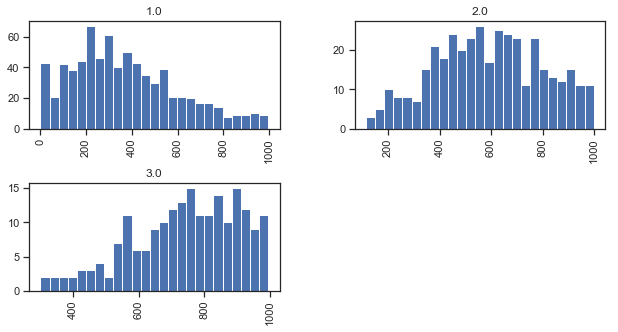

In [228]:
#Let's take a look at Term. Length's individually first.
combinedDBShortTerm.hist(column = 'Term. Length', by = 'Term. Number', bins = 25, figsize = (10,5))

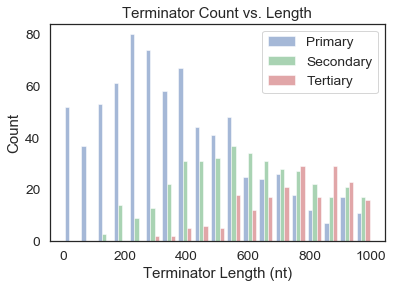

In [307]:
#An alternative way to plot this: 
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'Arial'

A = combinedDB[combinedDB['Term. Number'] == 1]['Term. Length']
B = combinedDB[combinedDB['Term. Number'] == 2]['Term. Length']
C = combinedDB[combinedDB['Term. Number'] == 3]['Term. Length']
#D = combinedDB[combinedDB['Term. Number'] == 4]['Term. Length']

bins = np.linspace(0, 1000, 20)

plt.hist([A,B,C], bins, alpha=0.5, label=['Primary', 'Secondary', 'Tertiary'])
plt.legend(loc='upper right')
plt.title("Terminator Count vs. Length")
plt.xlabel("Terminator Length (nt)")
plt.ylabel("Count")
#termLength.savefig("/Users/kershtheva/Desktop/Thesis/Chapter_4/TermCountLengthHist.png")
plt.show()
plt.figure

In [214]:
#Replace values of 0 with "No"
combinedDBShortTerm['Intragenic?'] = combinedDBShortTerm['Intragenic?'].replace(to_replace = 0, value="No")


/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


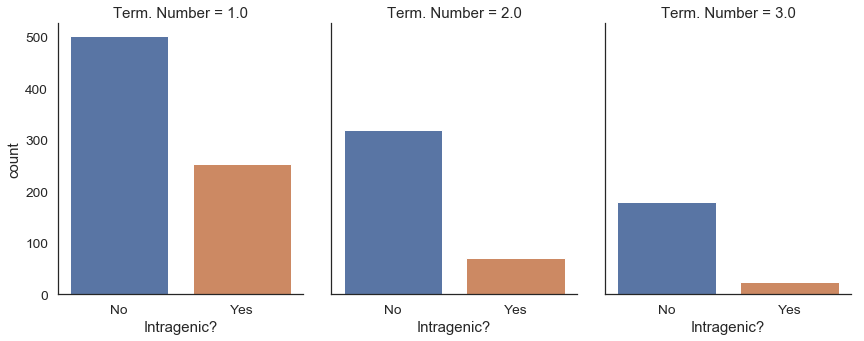

In [300]:
#Try to make bar plot of Term. number vs. count for 1 vs. 2 terminators

intragenic = sns.catplot("Intragenic?", 
                         col = "Term. Number", 
                         col_wrap = 3,
                         data = combinedDBShortTerm, 
                         kind = 'count', height = 5, aspect =0.8)


In [311]:
A = combinedDBShortTerm[combinedDBShortTerm['Term. Number'] == 1]
B = combinedDBShortTerm[combinedDBShortTerm['Term. Number'] == 2]
C = combinedDBShortTerm[combinedDBShortTerm['Term. Number'] == 3]

#A.describe()
#B.describe()
#C.describe()

**Primary terminator**: 372 &plusmn; 234 nt <br>
**Secondary terminator**: 590 &plusmn; 211 nt <br>
**Tertiary terminator**: 740 &plusmn; 163 nt

In [204]:
#Never included term counts!
#combinedDBShortTerm.plot(x='Term. Length', y='Term Counts', kind='box')

In [275]:
#Save both analysed dataframes
combinedDB.to_csv("/Users/kershtheva/Desktop/Thesis/Chapter_4/combinedDB071920.csv")
masterDBOperon4.to_csv("/Users/kershtheva/Desktop/Thesis/Chapter_4/geneDB071920.csv")

## 5e. Write algorithm to make primary terminator list for posList

## Figures and data I have
1. IGV has **read coverage data** that can be useful for EDA 
2. Plot **histogram** of frequency vs. 3'UTR length (primary term - stop codon)
3. Find primary, secondary and more putative 3'-UTR isoforms (found up to 2ary) (**done**)
4. Generate list of putative operons using predicted TSS and primary terminator (Used rockhopper) (**done**)
5. Make bar plot for number of primary terminators in next gene or not. 
6. Table of mean and standard deviations for 1ary, 2ary, 3ary terminator lengths

## Other data I'd like to get
1. **Logo plot** of nucleotide enrichment vs. position relative to terminator

## More speculative data

1. Try to find antisense overlap, which can be done manually or with code 
2. Find **RNA structure stabilities** with RNAfold algorithm
